# Image classification and feature extraction

### Init

In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.init
import glob
from PIL import Image
import random
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt

class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=34, device=torch.device('cpu')):
        super(VGGFeatureExtractor, self).__init__()
        model = torchvision.models.vgg19(pretrained=True)
        self.features = nn.Sequential(*list(model.features.children())[:(feature_layer + 1)])
        
        for k, v in self.features.named_parameters():
            v.requires_grad = False # # No need to backpropagate to variable

    def forward(self, x):
        output = self.features(x)
        return output

In [13]:
netF = VGGFeatureExtractor(feature_layer=37).cuda()
features = []
N = 300
files = glob.glob("../DIV2K_imageset/*.jpg")

print('Images processed: ',end='')

for idx,imgfile in enumerate(files):
    
    I = io.imread(imgfile) / 255
    tns = torch.tensor(I).permute(2,0,1)
    t = netF(tns.unsqueeze(0).float().cuda()).cpu()
    features.append(t.reshape(-1,).numpy())
    if idx % 10 == 0: print(idx,end=',')
    if idx == N:
        break

features = np.array(features)

Images processed: 0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,

### Build a search tree to find closest matches

In [14]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## Testing

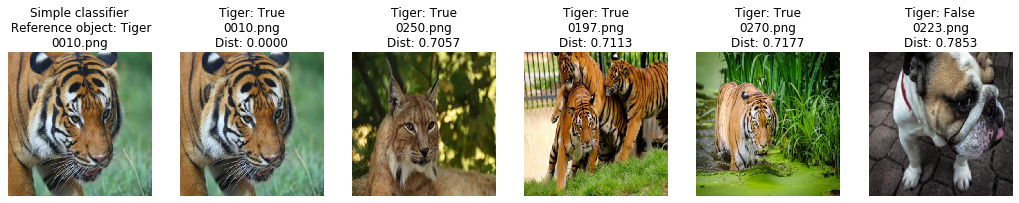

In [16]:
testidx = 10 # We know that this shows a tiger
label = 'Tiger'
dists, indices = knn.kneighbors([features[testidx-1]])

plt.figure(figsize=(18,3))

def plotimg(label,plotidx,div2k_idx,val=None):
    plt.subplot(1,len(indices[0])+1,plotidx)
    img = io.imread('DIV2K_imageset/%04d.jpg' % (int(div2k_idx)))
    img = transform.resize(img,(512,512,3))
    plt.imshow(img)
    if not val is None:
        plt.title('%s\n%04d.png\nDist: %0.4f' % (label,int(div2k_idx),val))
    else:
        plt.title('%s\n%04d.png' % (label,int(div2k_idx)))
    
    # remove axis
    plt.gca().axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    

plotimg('Simple classifier\n Reference object: %s' % label,1,testidx)

for idx,imgidx in enumerate(indices[0]):
    dist = dists[0,idx] # distance in feature space
    if dist < 0.75: # let us set a threshold
        plotimg('%s: True' % label,idx+2,imgidx+1,dist)    
    else:
        plotimg('%s: False' % label,idx+2,imgidx+1,dist)    